<a href="https://colab.research.google.com/github/XU2024/lab-analysis-4/blob/main/Last_Labanalysis4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial library includes and installations
run once - does not require you to edit anything

In [12]:
!pip install munch
import json
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from munch import munchify
import scipy.stats
from sklearn import linear_model, datasets



#Function definitions and constants
Run once - does not require you to edit anything

These functions are provided for you - see function definitions and comments for more information on their return values and usage

  1. `loadDataSet(filename)` - loads an individual .json file and checks it for really large jumps in major axis angle, which would indicate a problem with the fits
  1. `loadAllDataSets(startdir)` - loads all json files in a directory
  1. `meanOverTime(t,y,deltat)` - breaks data up into chunks about delta t long and calculates the average value of y over each chunk (assumes t is evenly spaced and monotonically increasing)
  1. `rateOfChange (t,y)` - calculates dy/dt (assumes t is monotonically increasing)
  1. `rateOfChangeAngular (t,theta)` - calculates dtheta/dt, taking into account wrapping every 2$\pi$ (assumes t is monotonically increasing and theta is in **radians**)
  1. `(m,b,m_e,b_e) fitLine(x,y)` - least squares fit to $y = (m\pm m_e)x + b\pm b_e$ $m_e$ and $b_e$ are the uncertainties (errors) in the estimates of $m$ and $b$
  1. `fitLineRansac(x,y)` - least squares fit to y = m x + b , discarding outliers - note that this function returns extra values besides m, b, m_e nd b_e: inlying and outlying points : uses [RANSAC](https://https://en.wikipedia.org/wiki/Random_sample_consensus) to find outliers
  1. `fitLineHuber(x,y)` - least squares fit to y = m x + b , discarding outliers - note that this function returns extra values besides m, b, m_e nd b_e: inlying and outlying points : uses [Huber](https://scikit-learn.org/stable/modules/linear_model.html#huber-regression) to find outliers

        

In [13]:
g=gaccel = 9.802

nyc_latitude =40.730610
deghr = np.rad2deg(3600)
omega_foucault = -15*np.sin(np.deg2rad(nyc_latitude))/deghr


MAJAXIS = 0
MINAXIS = 1
THETA = 2
DPHI = 3
MAGROT = 4
MAGROTRATE =5


#loads one data set (work from one lab group stored in a .json file)
#data can be accessed as either a dictionary or a structure
#ie dataset["fits"] and dataset.fits are the same thing
#setupNumber: number on the wall
#section: 1-4 which section data came from
#thetaWall: angle of a line parallel to the wall
#z0: calibrated magnet height
#filename: name of the json file
#fits: list of fits to individual trials
#   anglePath: path to angle data file
#   magPath: path to magnetometer data file
#   offset: (x,y) calculated offset of the magnetometer from 0
#   tiltAngle: calculated angle the magnet was tilted away from z-axis
#   L: calculated length of the string (from period)
#   B0: best estimate of magnetic field strength z0 away directly along magnet axis
#   t: time each orbit started: (N,)
#   orbit: fit parameters for each orbit (N,6)
# >>    orbit[:,MAJAXIS] is the major axis size (in meters) <<<
# >>    orbit[:,MAJAXIS] is the minor axis size (in meters) <<<
# >>    orbit[:,THETA] is the major axis angle <<<
#       orbit[:,DPHI] is the phase offset
#       orbit[:,MAGROT] is the orientation of the magnet tilt relative to the x-axis
#       orbit[:,MAGROTRATE] is the rate the bob was spinning about its axis per period


def loadDataSet(filename):
  file = open(filename,'r')
  results = json.load(file)
  file.close
  dataset = munchify(results) #can be accessed as a structure or a dict
  dataset.filename = filename
  valid = []
  for f in dataset.fits:
    f.offset = np.array(f.offset)
    f.orbit = np.array(f.orbit)
    f.t = np.array(f.t) 
    dp = np.diff(np.unwrap(f.orbit[:,THETA]))
    valid.append((np.abs(dp) < np.pi/4).all()) #extremely large jump from one swing to the next - bad fit
  bad = np.array(valid) == False
  if (bad.any()):
    print('{}: bad fits found in experiments {}'.format(filename, np.where(bad)[0]))
    dataset.fits = [dataset.fits[i] for i in np.where(valid)[0]]
  return dataset

def loadAllDataSets(startdir):
  files = sorted(glob.glob(startdir + '/*.json'))
  return [loadDataSet(f) for f in files]

#my = meanOverTime (t,y,deltat)
#calculates the mean value of y and dy/dt at approximate intervals of deltat
#   e.g. if deltat is 10, then my[0] is the average value of y between 
#   t[0] and t[0] + 10
#detalt is adjusted downward to evenly divide the whole range
#   e.g. if deltat is 100 and t ranges from 0 to 110 seconds, then delta t will be 55
def meanOverTime (t, y, deltat):
  numpts = int(np.ceil((t[-1]-t[0])/deltat)) + 1
  inds = np.linspace(0,len(t),numpts, endpoint=False, dtype=int)
  dt = np.gradient(t)
  my = np.diff((np.cumsum(y)*dt)[inds])/np.diff(t[inds])
  return my

#dy_dt = rateOfChange(t,y)  
def rateOfChange (t,y):
  return np.gradient(y)/np.gradient(t)

#dtheta_dt = rateOfChangeAngular(theta)
#unwraps theta so that there aren't any jumps bigger than pi before taking derivative
def rateOfChangeAngular(t,theta):
  return np.gradient(np.unwrap(theta))/np.gradient(t)

#(m,b,m_e,b_e) = fitLine(x,y)
#least squares fit to y = m x + b : m_e,b_e are uncertainties in m,b
def fitLine(x,y):
  p = np.polyfit(x,y,1)
  res = y - p[0]*x - p[1]
  m_e = np.sqrt(np.var(res)/np.sum((x-np.mean(x))**2))
  b_e = np.sqrt(np.mean(x**2))*m_e
  return (p[0],p[1],m_e,b_e)
  

def fitLineHuber(x,y,epsilon=2):
  huber = linear_model.HuberRegressor(epsilon=epsilon)
  huber.fit(x.reshape(-1,1),y)
  outlier_mask = huber.outliers_
  inlier_mask = np.logical_not(outlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  return (m,b,me,be,xi,yi,xo,yo)

#((m,b,me,be,xi,yi,xo,yo) = fitLineRansac(x,y)
#least squares fit to y = m x + b , discarding outliers
#xi,yi are x,y values used (inliers) 
#xo.yo are x,y values discarded (outliers)
def fitLineRansac(x,y):
  #print(np.median(np.abs(y - np.median(y))))
  ransac = linear_model.RANSACRegressor()
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = np.median(np.abs(res))
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))

  ransac.stop_probability = 1
  ransac.max_trials = 10000
  ransac.min_samples = 0.1
  res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  ransac.residual_threshold = 2.5*np.std(res)
  ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  inlier_mask = ransac.inlier_mask_
  
  # res = y[inlier_mask]-ransac.predict(x.reshape(-1,1))[inlier_mask,0]
  # ransac.residual_threshold = np.median(np.abs(res))
  # ransac.fit(x.reshape(-1,1),y.reshape(-1,1))
  # inlier_mask = ransac.inlier_mask_

  outlier_mask = np.logical_not(inlier_mask)
  (m,b,me,be) = fitLine(x[inlier_mask], y[inlier_mask])
  xi = x[inlier_mask]
  yi = y[inlier_mask]
  xo = x[outlier_mask]
  yo = y[outlier_mask]
  print(ransac.n_trials_)
  return (m,b,me,be,xi,yi,xo,yo)

#Fetch the data to be analyzed
** Change the first github repository name to match your username (lab4-individual-data-yourname)  **
then run once

In [14]:
!rm -rf mydata/
!rm -rf data/
!git clone https://github.com/NYUExperimentalPhysics1-2021/lab4-individual-data-XU2024 mydata #change to your github username
!git clone https://github.com/NYUExperimentalPhysics1-2021/lab4-shared-data-whole-class data

Cloning into 'mydata'...
remote: Enumerating objects: 61, done.
remote: Total 61 (delta 0), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (61/61), done.
Cloning into 'data'...
remote: Enumerating objects: 194, done.
remote: Total 194 (delta 0), reused 0 (delta 0), pack-reused 194
Receiving objects: 100% (194/194), 51.35 MiB | 12.02 MiB/s, done.
Resolving deltas: 100% (34/34), done.


#load the data sets to be analyzed
run once

1. `mydata = loadAllDataSets('/content/mydata/')[0]` - load your data -- the [0] is because you only have one data set, so we'll take it out of the list to look at it alone
1. `alldata = loadAllDataSets('/content/data/')` - load everyone's data - each element of this list is one dataset


## fields in dataset structure
- `setupNumber`: number on the wall
- `section`: 1-4 which section data came from
- `thetaWall`: angle of a line parallel to the wall
- `z0`: calibrated magnet height
- `filename`: name of the json file
- `fits`: list of fits to individual trials
   - `anglePath`: path to angle data file
   - `magPath`: path to magnetometer data file
   - `offset`: (x,y) calculated offset of the magnetometer from 0
   - `tiltAngle`: calculated angle the magnet was tilted away from z-axis
   - `L`: calculated length of the string (from period)
   - `B0`: best estimate of magnetic field strength z0 away directly along magnet axis
   - `t`: time each orbit started: (N,)
   - `orbit`: fit parameters for each orbit (N,6)
        - `orbit[:,MAJAXIS]` is the **major axis** size (in meters) 
        - `orbit[:,MAJAXIS]` is the **minor axis** size (in meters) 
        - `orbit[:,THETA]` is the **angle of the major axis** 
        - `orbit[:,DPHI]` is the phase offset
        - `orbit[:,MAGROT]` is the orientation of the magnet tilt relative to the x-axis
        - `orbit[:,MAGROTRATE]` is the rate the bob was spinning about its axis per period

In [15]:
mydata = loadAllDataSets('/content/mydata/')[0]
alldata = loadAllDataSets('/content/data/')

/content/data/section1setup4-24-Nov-2021.json: bad fits found in experiments [1]
/content/data/section3setup1-16-Nov-2021.json: bad fits found in experiments [0]
/content/data/section3setup6-16-Nov-2021.json: bad fits found in experiments [0]


#Part 1 - plot the precession rate vs. the predicted precession rate for your experiments

1. Choose a time bin size, $\Delta t$ to average over. Start with `deltat = 60` seconds, but try a few different values once everything works.
1. Create empty lists to store the following results: `predictedrate`, `measuredrate`
1. Loop over each fit (trial) in your set (`for f in mydata.fits:`)
    1. Calculate $\omega = \sqrt{g/L}$ Note that $g$ is defined in the variable `gaccel` and $L$ can be found in `f.L`
    1. Extract the time, major axis ($a$), minor axis ($b$), and angle ($\theta$) of the swing. e.g. `t = f.t` for time; `a = f.orbit[:,MAJAXIS]` for major axis, etc.
    1. Calculate the predicted precession rate (without foucault precession):  $\Omega_{pred} = 0.375 * \omega * \frac{a b}{L^2}$
    1. Calculate the measured precession rate as $\frac{d \theta}{d t}$. Make sure to use `rateOfChangeAngular`
    1. For both the predicted and measured rates, calculate the means over time, using `meanOverTime` with your stored value of `deltat`
    1. Append the mean-over-time predicted and measured rates to predictedrate and measuredrate. 
    1. Use `plt.scatter(pred*deghr,meas*deghr)` to make a scatter plot of the results of this trial. Here pred and meas are the mean-over-time rates you just calculated. Plotting the data one trial at a time should result in each trial showing up as different colored dots. If the dots are too large, add `marker='.'` after the arguments of the scatter command

1. Convert your lists of fit values to a single array: `pred = np.concatenate(predictedrate)`, `meas = np.concatenate(measuredrate)`
1. Plot the prediction of the model and foucault precession: `plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')` as a dashed magenta line
1. Fit the measured rate to the predicted rate using `fitLine` and plot the prediction as a black solid line. Make sure to multiply by `deghr`. Add `label = 'measured'` to the command. 
1. Use `plt.legend()` to make a legend
1. Add x and y labels. Here's how I made my x-label `plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')`
1. Print out the following information: slope of the linear fit between predicted (x) and measured (y) values (would be 1 if measured rates exactly match predicted rates); 2 intercept of the linear fit, multiplied by deghr (would be -9.8 deg/hr if only perturbing influence is foucault precession)




315.73269009657594


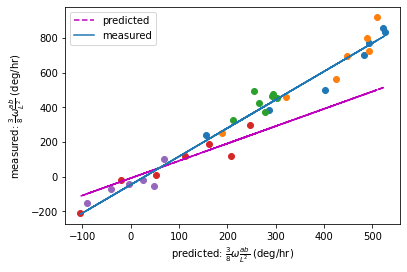

In [16]:
## your code below

deltat = 60
predictedrate, measuredrate = [],[]

for f in mydata.fits:
  omega = (gaccel/f.L)**0.5
  t = f.t
  a = f.orbit[:,MAJAXIS]
  b = f.orbit[:,MINAXIS]
  angle = f.orbit[:,THETA]
  Omega = 0.375 * omega * ((a*b)/(f.L**2))
  ProcessionRate = rateOfChangeAngular(t, angle)
  pred = meanOverTime(t, Omega, deltat)
  meas = meanOverTime(t, ProcessionRate, deltat)
  predictedrate.append(pred)
  measuredrate.append(meas)
  plt.scatter(pred*deghr, meas*deghr)

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)
plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')

m,b,m_e,b_e = fitLine(pred, meas)
plt.plot(pred*deghr, (m*pred+b)*deghr, label = 'measured')


plt.legend()
plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')

print(np.std(meas*deghr))


#Questions

1. To what extent are your data consistent with the theory? Do you see qualitative agreement (i.e. the direction matches the predicted direction and depends on the size of $ab/L^2$)? Is the measured rate linear in $ab/L^2$ ? Are the slope and intercepts what you would expect?

It does have a positive relation, but it is not so consistent. Measured line is also not in the size.

1. Let's think about the intercept a little more. Say you can measure the change in angle with an accuracy of 1 degree over your 5 minute experiment.
    1. What accuracy is this in terms of degrees per hour? 

     12 degrees an hour.

    1. When we calculate s.e.m., $\sigma_{mean} = \frac{\sigma}{\sqrt{N}}$. The same rule will apply to the error in the intercept ($\sigma_{intercept} = \frac{\sigma}{\sqrt{N}}$), if the mean of the x-data is 0. What error in the intercept would you expect for the number of measurements you made?

      += 167 the std(meas/deghr) I got.

    1. How does this compare to the actual error reported by fitLine?

      This much more than the error.


    1. How many 5-minute experiments would you need to get $\sigma_{intercept}$ down to 1 degree/hour?

      12 

1. If you didn't already, play with `deltat` (try 10, 100 and 300 - don't go below 3 seconds or you might see an error if a time interval has no crossings) and examine how the graph and the fit change. How does a longer `deltat` change the accuracy of your measured rate? Setting `deltat` to 10,000 will make the software treat every trial as a single measurement. 

  There will be fewer points as deltat increases but the line doesn't change, it has no relation with acuracy.


#Everyone's data
Now let's apply the same procedure to look at the whole class data set. You should be able to basically reuse your code above. Just wrap everything in another loop

```python
ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    ....
    ....
```



Text(0, 0.5, 'measured: $\\frac{3}{8}\\omega \\frac{a b}{L^2}$ (deg/hr)')

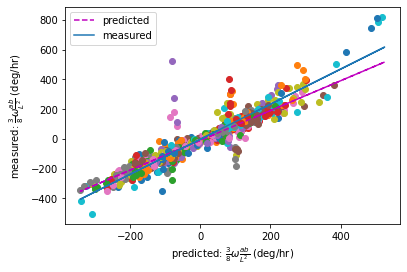

In [ ]:
#your code below

ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    omega = (gaccel/f.L)**0.5
    t=f.t
    a=f.orbit[:,MAJAXIS]
    b=f.orbit[:,MINAXIS]
    angle=f.orbit[:,THETA]
    Omega=0.375*omega*((a*b)/(f.L**2))
    ProcessionRate = rateOfChangeAngular(t, angle)
    pred=meanOverTime(t, Omega, deltat)
    meas=meanOverTime(t, ProcessionRate, deltat)
    predictedrate.append(pred)
    measuredrate.append(meas)
    plt.scatter(pred*deghr, meas*deghr)

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)
plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')

m,b,m_e,b_e = fitLine(pred, meas)

plt.plot(pred*deghr, (m*pred+b)*deghr, label = 'measured')


plt.legend()
plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')

#Deal with possible outliers

If you look at the class data, you can see the line is being "pulled up" by some measurements with very large predicted and measured rates.

1. One way to deal with this would be to focus only on a smaller range. IE analyze the data where the predicted rate is between -200 and 200 deg/hr. 
1. There are also robust fitting strategies you can use. I've written function `fitLineRansac` and `fitLineHuber` that use these to identify "outliers" - data you discard as unlikely to be correctly measured/part of the same data set. 

Please...

1. Plot all the data as a scatter plot overlaid with the linear fit in black and the prediction as a dashed magenta line (slope = 1, intercept = -9.8 deg/hr)
1. Make a second figure. Divide the data by whether the absolute value of the predicted rate is more or less than 200 deg/hr. Plot the "inliers" (abs < 200) in blue and the "outliers" in red. Overlay this figure with the linear fit to only the inliers
1. Make a third figure. Use the `fitLineHuber` function to estimate the model parameters and identify inliers and outliers. As before, plot the inliers in blue, the outliers in red, and overlay the figure with the linear fit to only the inliers
1. Make a fourth figure that's the same as the third, except use the `fitLineRanac` function. 
1. Print the slope and intercept and their uncertainties for each method you used. 


Repeat these for different values of `deltat` Which time interval gives you the lowest uncertainty estimate of the slope and the intercept? Does which `deltat` is best depend on how you treat the outliers?


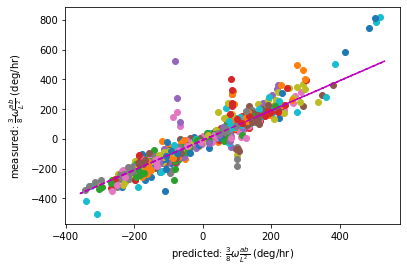

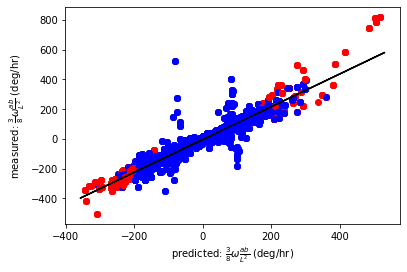

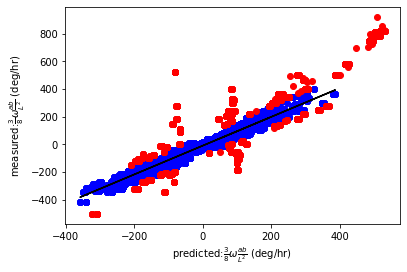

10000


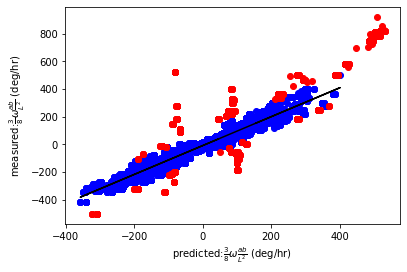

In [11]:
## your code here

ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    omega = (gaccel/f.L)**0.5
    t = f.t
    a = f.orbit[:,MAJAXIS]
    b = f.orbit[:,MINAXIS]
    angle = f.orbit[:,THETA]
    Omega = 0.375 * omega * ((a*b)/(f.L**2))
    ProcessionRate = rateOfChangeAngular(t, angle)
    pred = meanOverTime(t, Omega, deltat)
    meas = meanOverTime(t, ProcessionRate, deltat)
    predictedrate.append(pred)
    measuredrate.append(meas)
    plt.scatter(pred*deghr, meas*deghr)

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)
plt.plot(pred*deghr, (pred + omega_foucault)*deghr, 'm--', label = 'predicted')

plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.show()

ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    omega = (gaccel/f.L)**0.5
    t = f.t
    a = f.orbit[:,MAJAXIS]
    b = f.orbit[:,MINAXIS]
    angle = f.orbit[:,THETA]
    Omega = 0.375 * omega * ((a*b)/(f.L**2))
    ProcessionRate = rateOfChangeAngular(t, angle)
    pred = meanOverTime(t, Omega, deltat)
    meas = meanOverTime(t, ProcessionRate, deltat)
    predictedrate.append(pred)
    measuredrate.append(meas)
    count = 0
    while count < len(pred):
      if np.abs(pred[count]*deghr) < 200:
        plt.scatter(pred*deghr, meas*deghr, color='blue')
      else:
        plt.scatter(pred*deghr, meas*deghr, color='red')
      count += 1

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)

m,b,m_e,b_e = fitLine(pred, meas)

plt.plot(pred*deghr, (m*pred+b)*deghr, color = 'black')

plt.xlabel(r'predicted: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured: $\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.show()

ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    omega = (gaccel/f.L)**0.5
    t = f.t
    a = f.orbit[:,MAJAXIS]
    b = f.orbit[:,MINAXIS]
    angle = f.orbit[:,THETA]
    Omega = 0.375 * omega * ((a*b)/(f.L**1.35))
    ProcessionRate = rateOfChangeAngular(t, angle)
    pred = meanOverTime(t, Omega, deltat)
    meas = meanOverTime(t, ProcessionRate, deltat)
    predictedrate.append(pred)
    measuredrate.append(meas)
    plt.scatter(pred*deghr, meas*deghr)


pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)

m,b,m_e,b_e,a,b,c,d=fitLineHuber(pred*deghr,meas*deghr)

plt.scatter(a,b,color='blue')
plt.scatter(c,d,color='red')
m,b,m_e,b_e=fitLine(a,b)
plt.plot(a,m*a+b,color='black')
plt.xlabel(r'predicted:$\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured:$\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.show()

ratepred = []
ratemeas = []
deltat = 100
for data in alldata:
  for f in data.fits:
    omega = (gaccel/f.L)**0.5
    t = f.t
    a = f.orbit[:,MAJAXIS]
    b = f.orbit[:,MINAXIS]
    angle = f.orbit[:,THETA]
    Omega = 0.375 * omega * ((a*b)/(f.L**2))
    ProcessionRate = rateOfChangeAngular(t, angle)
    pred = meanOverTime(t, Omega, deltat)
    meas = meanOverTime(t, ProcessionRate, deltat)
    predictedrate.append(pred)
    measuredrate.append(meas)
    plt.scatter(pred*deghr, meas*deghr)

pred = np.concatenate(predictedrate)
meas = np.concatenate(measuredrate)

m,b,m_e,b_e,a,b,c,d= fitLineRansac(pred*deghr,meas*deghr)

plt.scatter(a,b,color='blue')
plt.scatter(c,d,color='red')
m,b,m_e,b_e=fitLine(a,b)
plt.plot(a,m*a+b,'k-')
plt.xlabel(r'predicted:$\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.ylabel(r'measured:$\frac{3}{8}\omega \frac{a b}{L^2}$ (deg/hr)')
plt.show()

#Questions

1. To what extent are your data consistent with the theory? Do you see qualitative agreement (i.e. the direction matches the predicted direction and depends on the size of $ab/L^2$)? Is the measured rate linear in $ab/L^2$ ? Are the slope and intercepts what you would expect?

  this data is  consistent in a linear relationship with $ab/L^2$. The slope and intercepts are in my expectation

1. Do the outliers identified by the algorithms make sense to you? The fitLineHuber takes an optional argument (epsilon=...) that sets how strictly outliers are excluded. I've set the default to 2. Try 1.35 (the toolkit default). Are most of the excluded data truly outliers? If your goal is to make an accurate estimate of the slope, what are the tradeoffs of excluding more outlying data?

  I don' think much of the data are outliers. Removing more data might influence the accuracy of result, so I will just remove some exxtreme values.
  
  

1. Which time interval gives you the lowest uncertainty estimate of the slope and the intercept? Does which deltat is best depend on how you treat the outliers?

  The lowest uncertainty estimate would be in the domain (-100,100) as there is no extreme value and all the points are concentrated in the trend, so this may give lowest uncertainty..
  


#Slice and dice the dataset

Select a `deltat` you think gives the most accurate accounting of the motion. Please make the scatter plots of measured vs. predicted rates again (please continue to scale by degrees per hour). 

1. In one plot, please color the data according to the section number
2. In a second plot, please color the data according to the setup number
3. In a third plot, please color the data by whether the motion was parallel to the wall. Consider the motion to be parallel if it is within 45 degrees of the angle of the wall. If theta is the angle of the swing, then this code would be true for motion parallel to the wall `np.abs(np.cos(theta - np.deg2rad(data.thetaWall))) < np.sqrt(0.5)`

Once you've sliced and diced for plotting, please find the slope and intercepts for each section, each setup, and parallel/away from the wall using a method for handling outliers you select. 

In [ ]:
#your code here

